# Setup

**Imports**

In [1]:
import datetime as dt
from math import log
import IPython

import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt

import sys
from scipy.signal import chirp, spectrogram, stft, sweep_poly

import Levenshtein
from itertools import product

rng = np.random.default_rng()
np.set_printoptions(threshold=sys.maxsize)

from math import log, radians, sin, cos, sqrt, asin


import geopandas as gpd
import contextily as cx
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh

from pygsp import graphs

# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [139]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

In [140]:
signal, symbols = X_train[2], y_train[2]
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

D 6 A 8 3 D 1 8 B 9


In [141]:
symbols = [["1", "2", "3", "A"],
           ["4", "5", "6", "B"],
           ["7", "8", "9", "C"],
           ["*", "0", "#", "D"]]

f1 = np.array([697, 770, 852, 941])
f2 = np.array([1209, 1336, 1477, 1633])

sigma = 1

In [142]:
def predict_signal(signal, sigma=1, alpha=0.001, nperseg=256, noverlap=8, min_break_time=0.1, min_energy=0.2):

    # Compute penalty parameter based on BIC approach
    pen_bic = alpha * sigma**2 * np.log(len(signal))

    # Compute spectrogram
    f, t, Sxx = spectrogram(signal, FS, nperseg=nperseg, noverlap=noverlap)

    # Limit analysis to frequencies used in DTMF (650-1800)
    min_freq = 650
    max_freq = 1800
    idx_min_freq = np.argmin(np.abs(f - min_freq))
    idx_max_freq = np.argmin(np.abs(f - max_freq))

    # Set upper and lower bound for differences between DTMF tones
    min_freq_dist = 250
    max_freq_dist = 950

    # Use PELT change-point detection to find breakpoints
    algo = rpt.Pelt(model="l1", jump=1)
    predicted_bkps = algo.fit_predict(signal=Sxx.T, pen=pen_bic)

    # Analyse each segment
    predictions_segments = []
    for idx_bkp in range(0, len(predicted_bkps[:-2]), 2): # Odd-indexes = breakpoints, even indexes = silence
        # Get start and end times of segment
        start_time = t[predicted_bkps[idx_bkp]]
        end_time = (
            t[predicted_bkps[idx_bkp + 1]]
            if predicted_bkps[idx_bkp + 1] < len(t)
            else t[-1]
        )

        # Extract relevant part of spectrogram for segment
        Sxx_zone = Sxx[idx_min_freq:idx_max_freq, predicted_bkps[idx_bkp] : predicted_bkps[idx_bkp + 1],]

        # Find two frequencies with highest average energy in the segment
        energy = np.mean(Sxx_zone, axis=1)
        freqs = f[idx_min_freq + np.argsort(energy)[-2:]]

        # Skip if invalid segment
        if (
            np.abs(freqs[0] - freqs[1]) < min_freq_dist
            or np.abs(freqs[0] - freqs[1]) > max_freq_dist
        ):
            continue

        # Identify closest DTMF low and high frequencies
        distances_f1 = np.min(
            np.abs(f1[:None, None] - freqs[None, None, :]), axis=(0, 2)
        )
        distances_f2 = np.min(
            np.abs(f2[:None, None] - freqs[None, None, :]), axis=(0, 2)
        )
        pred_f1 = np.argmin(distances_f1)
        pred_f2 = np.argmin(distances_f2)

        # Store the detected symbol and its properties
        predictions_segments.append(
            {
                "freqs": freqs,
                "symbol": symbols[pred_f1][pred_f2],
                "start_time": start_time,
                "end_time": end_time,
                "energy": np.sum(np.sort(energy)[-2:]) / (end_time - start_time),
            }
        )

    # Merge consecutive segments with same symbol
    combined_segments = [predictions_segments[0]]
    for idx, next_segment in enumerate(predictions_segments[1:]):
        if (
            next_segment["symbol"] == combined_segments[-1]["symbol"]
            and next_segment["start_time"] - combined_segments[-1]["end_time"]
            < min_break_time
        ):
            combined_segments[-1]["end_time"] = next_segment["end_time"]
        else:
            combined_segments.append(next_segment)

    # Filter out segments with low energy
    combined_segments = [segment for segment in combined_segments if segment["energy"] > min_energy]

    # Extract predicted symbols from filtered segments
    predicted_symbols = [segment["symbol"] for segment in combined_segments]

    return predicted_symbols

In [143]:
def levenshtein_accuracy_score(y_true, y_pred):
    true_label = "".join(y_true)
    prediction = "".join(y_pred)
    distance = Levenshtein.distance(true_label, prediction)
    accuracy = 1 - distance / max(len(true_label), len(prediction))
    return accuracy

In [144]:
def grid_search_predict_signal(X_train, y_train):
    
    # Define hyperparameter grid
    alpha_values = [0.001]
    nperseg_values = [256, 512, 1024]
    noverlap_values = [2, 4, 8]
    min_break_time_values = [0.1, 0.2, 0.3]
    min_energy_values = [0.05, 0.1, 0.2]

    # Initialize variables to track best parameters and score
    best_params = None
    best_score = -np.inf

    # Iterate over all combinations of hyperparameters
    for alpha, nperseg, noverlap, min_break_time, min_energy in product(
        alpha_values, nperseg_values, noverlap_values, min_break_time_values, min_energy_values
    ):
        print(alpha, nperseg, noverlap, min_break_time, min_energy)

        accuracies = []

        # Evaluate predictions for each signal in X_train
        for signal, true_sequence in zip(X_train, y_train):
            # Predict the sequence using current parameters
            predicted_sequence = predict_signal(
                signal=signal,
                sigma=1,
                alpha=alpha,
                nperseg=nperseg,
                noverlap=noverlap,
                min_break_time=min_break_time,
                min_energy=min_energy
            )

            # Compute Levenshtein accuracy score for this signal
            accuracy = levenshtein_accuracy_score(true_sequence, predicted_sequence)
            accuracies.append(accuracy)

        # Compute average accuracy across all signals for this set of hyperparameters
        avg_score = np.mean(accuracies)

        # Update best hyperparameters if the current score is better
        if avg_score > best_score:
            best_score = avg_score
            best_params = {
                "alpha": alpha,
                "nperseg": nperseg,
                "noverlap": noverlap,
                "min_break_time": min_break_time,
                "min_energy": min_energy,
                "score": best_score
            }

    return best_params

best_hyperparams = grid_search_predict_signal(X_train=X_train, y_train=y_train)
print("Best Hyperparameters:", best_hyperparams)

0.001 256 2 0.1 0.05
0.001 256 2 0.1 0.1
0.001 256 2 0.1 0.2
0.001 256 2 0.2 0.05
0.001 256 2 0.2 0.1
0.001 256 2 0.2 0.2
0.001 256 2 0.3 0.05
0.001 256 2 0.3 0.1
0.001 256 2 0.3 0.2
0.001 256 4 0.1 0.05
0.001 256 4 0.1 0.1
0.001 256 4 0.1 0.2
0.001 256 4 0.2 0.05
0.001 256 4 0.2 0.1
0.001 256 4 0.2 0.2
0.001 256 4 0.3 0.05
0.001 256 4 0.3 0.1
0.001 256 4 0.3 0.2
0.001 256 8 0.1 0.05
0.001 256 8 0.1 0.1
0.001 256 8 0.1 0.2
0.001 256 8 0.2 0.05
0.001 256 8 0.2 0.1
0.001 256 8 0.2 0.2
0.001 256 8 0.3 0.05
0.001 256 8 0.3 0.1
0.001 256 8 0.3 0.2
0.001 512 2 0.1 0.05
0.001 512 2 0.1 0.1
0.001 512 2 0.1 0.2
0.001 512 2 0.2 0.05
0.001 512 2 0.2 0.1
0.001 512 2 0.2 0.2
0.001 512 2 0.3 0.05
0.001 512 2 0.3 0.1
0.001 512 2 0.3 0.2
0.001 512 4 0.1 0.05
0.001 512 4 0.1 0.1
0.001 512 4 0.1 0.2
0.001 512 4 0.2 0.05
0.001 512 4 0.2 0.1
0.001 512 4 0.2 0.2
0.001 512 4 0.3 0.05
0.001 512 4 0.3 0.1
0.001 512 4 0.3 0.2
0.001 512 8 0.1 0.05
0.001 512 8 0.1 0.1
0.001 512 8 0.1 0.2
0.001 512 8 0.2 0.05
0.0

Best hyperparemeters:
- alpha = 0.001
- nperseg = 256
- noverlap = 8
- min_break_time = 0.1
- min_energy = 0.2

-> Accuracy score: 84.38%

# Question 2

In [145]:
X_test = np.load("X_test.npy", allow_pickle=True).tolist()
y_test = np.load("y_test.npy", allow_pickle=True).tolist()

for i in range(len(X_test)):
    print(f"Predicted signal {i+1}: {predict_signal(X_test[i], alpha=0.001, nperseg=256, noverlap=8, min_break_time=0.1, min_energy=0.2)}")
    print(f"True signal {i+1}: {y_test[i]}")
    print()

Predicted signal 1: ['7', '2', '1', 'C', '9', '9']
True signal 1: ['7', '2', '1', 'C', '9', '9']

Predicted signal 2: ['1', '#', '2', '#']
True signal 2: ['1', '#', '2', '#']



# Question 3

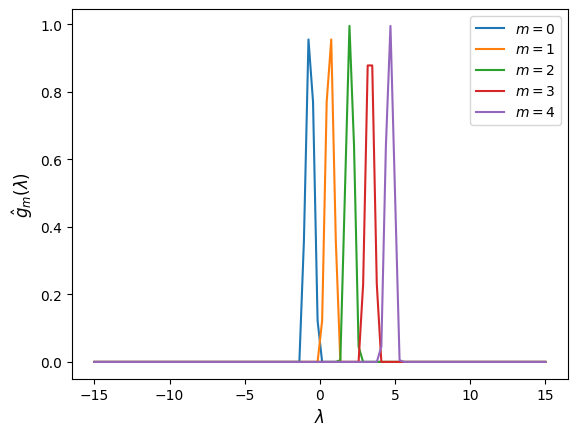

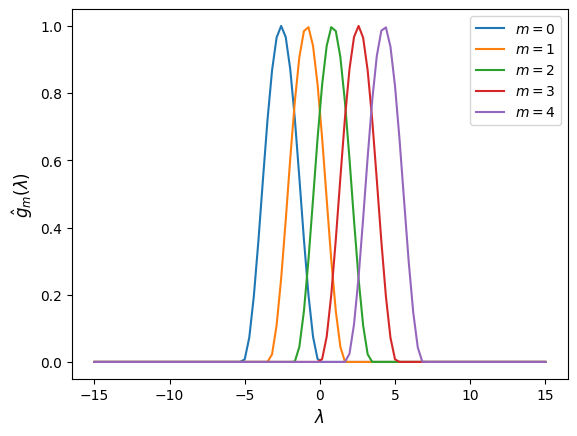

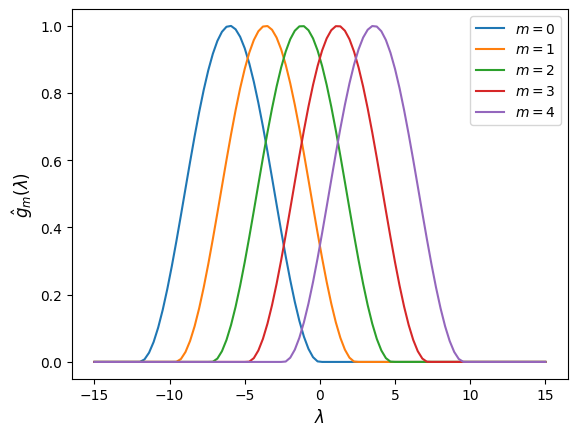

In [146]:
def g(lam, R, M=9, lam_n=12):
    a = lam_n/(M + 1 - R)
    return 0.5 * (1 + np.cos(2 * np.pi * (lam/(a * R) + 0.5))) * np.where((-R * a <= lam) & (lam < 0), 1, 0)

def g_m(lam, m, R, M=9, lam_n=12):
    a = lam_n/(M + 1 - R)
    return g(lam - a * m, R, M, lam_n)

lam = np.linspace(-15, 15, 100)

for R in [1, 3, 5]:
    for m in range(5):
        plt.plot(lam, g_m(lam, m, R), label=r"$m=$"+str(m))

    plt.xlabel(r"$\lambda$", fontsize=12)
    plt.ylabel(r"$\hat{g}_m(\lambda)$", fontsize=12)
    plt.legend()

    plt.show()

# Question 4

The graph is not connected. Adjusting threshold...
The graph is connected, with 37 nodes, 75 edges
The stations with missing values are ['AURAY', 'BELLE ILE-LE TALUT', 'BIGNAN', 'DINARD', 'GUERANDE', 'GUISCRIFF SA', 'ILE DE GROIX', 'ILE-DE-BREHAT', 'KERPERT', 'LORIENT-LANN BIHOUE', 'LOUARGAT', 'MERDRIGNAC', 'MORLAIX_AERO', 'NOIRMOUTIER EN', 'PLEUCADEUC', 'PLEYBER-CHRIST SA', 'PLOERMEL', 'PLOUGUENAST', "PLOUMANAC'H", 'PLOVAN', 'POMMERIT-JAUDY', 'PONTIVY', 'PTE DE CHEMOULIN', 'PTE DE PENMARCH', 'PTE DU RAZ', 'QUINTENIC', 'ROSTRENEN', 'SAINT-CAST-LE-G', 'SAINT-JOACHIM_SAE', 'SARZEAU SA', 'SIBIRIL S A', 'SPEZET', 'ST BRIEUC', 'ST-SEGAL S A', 'THEIX', 'TREGUNC', 'VANNES-SENE']
The threshold is equal to 0.83
The signal is the least smooth at 2014-01-10 09:00:00
The signal is the smoothest at 2014-01-24 19:00:00


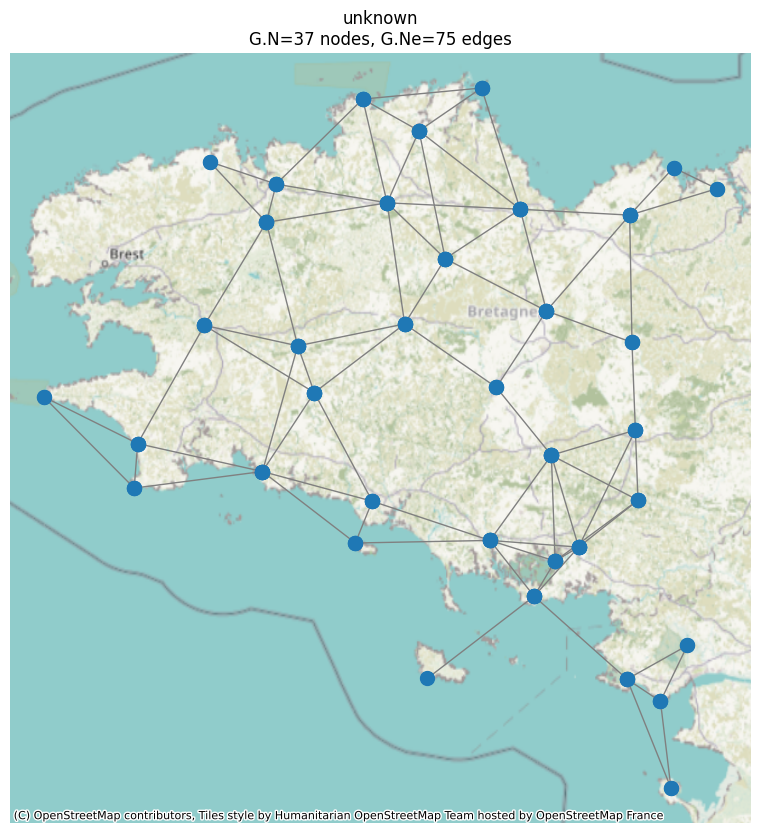

In [2]:
data_df, stations_df, description = load_molene_meteo_dataset()
data_df["temp"] = data_df.t - 273.15

temperature_df = data_df.pivot(index="date", values="temp", columns="station_name")
temperature_df = temperature_df.dropna(axis=1)
STATION_LIST = temperature_df.columns.values.tolist()

stations_df = stations_df[stations_df.Nom.isin(STATION_LIST)]
data_df = data_df[data_df.station_name.isin(STATION_LIST)].reset_index().drop("index", axis="columns")

stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df.Longitude, stations_df.Latitude),
).set_crs("EPSG:4326")

def get_geodesic_distance(point_1, point_2) -> float:
    lon1, lat1 = point_1
    lon2, lat2 = point_2
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371
    return c * r

stations_np = stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

sigma = np.median(dist_mat_condensed)

def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    exp_similarity = np.exp(-(condensed_distance_matrix ** 2) / (bandwidth ** 2))
    return np.where(exp_similarity > threshold, exp_similarity, 0.0)

threshold = 1.0 
adjacency_matrix = squareform(get_exponential_similarity(dist_mat_condensed, sigma, threshold))

G = graphs.Graph(adjacency_matrix)

if not G.is_connected():
    print("The graph is not connected. Adjusting threshold...")
    while not G.is_connected():
        threshold -= 0.01
        adjacency_matrix = squareform(get_exponential_similarity(dist_mat_condensed, sigma, threshold))
        G = graphs.Graph(adjacency_matrix)

print(f"The graph is {'not ' if not G.is_connected() else ''}connected, with {G.N} nodes, {G.Ne} edges")

ax = stations_gdf.geometry.plot(figsize=(15, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(stations_np)
G.plot(ax=ax)


def compute_signal_smoothness(temperature_df, graph):
    smoothness = []
    for time in temperature_df.index:
        temp_vector = temperature_df.loc[time].values
        smoothness.append((temp_vector.T @ graph.L @ temp_vector))
    return smoothness


smoothness = compute_signal_smoothness(temperature_df, G)

least_smooth_time = temperature_df.index[np.argmax(smoothness)]
most_smooth_time = temperature_df.index[np.argmin(smoothness)]

print(f"The stations with missing values are {STATION_LIST}")
print(f"The threshold is equal to {round(threshold, 2)}")
print(f"The signal is the least smooth at {least_smooth_time}")
print(f"The signal is the smoothest at {most_smooth_time}")

# Question 5

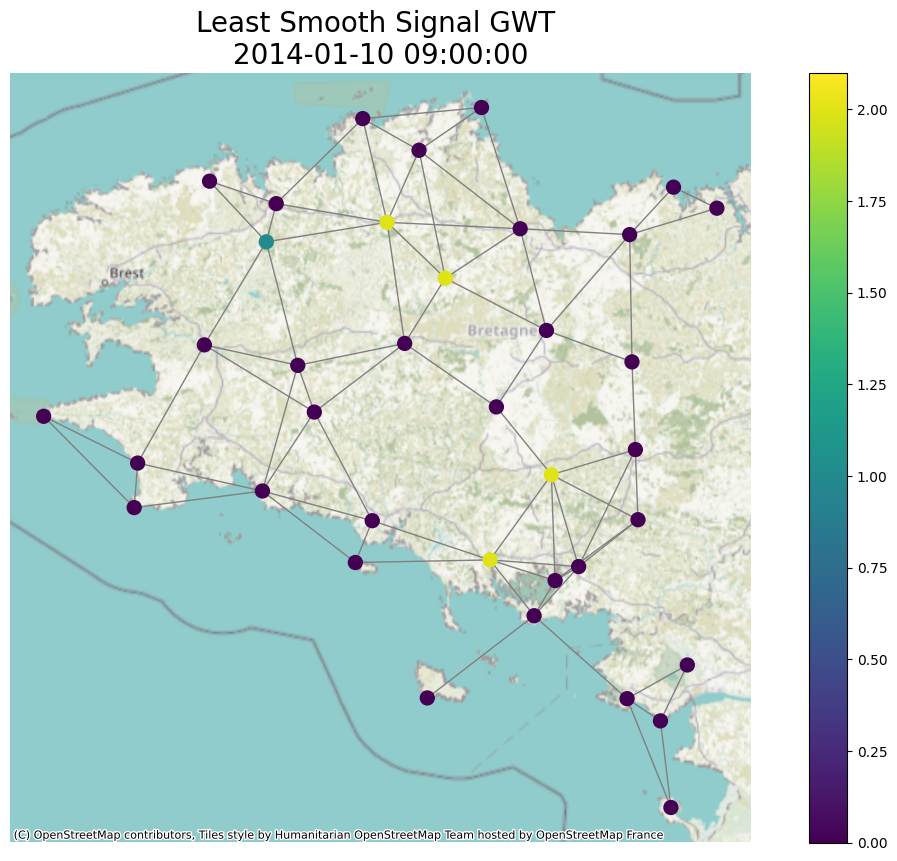

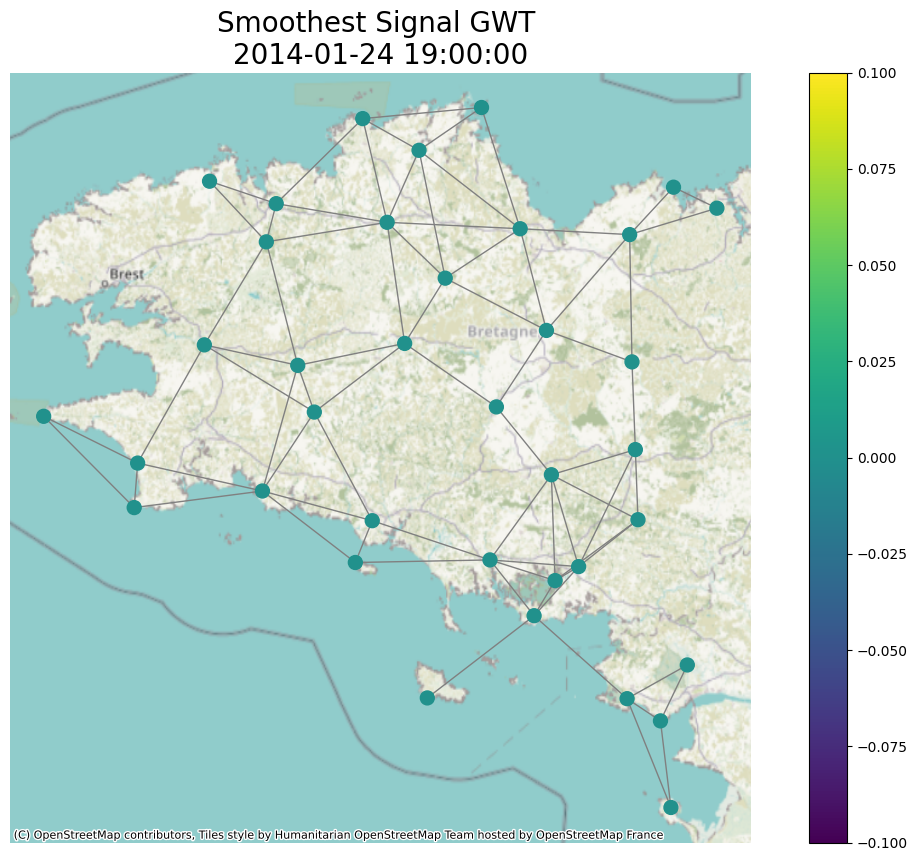

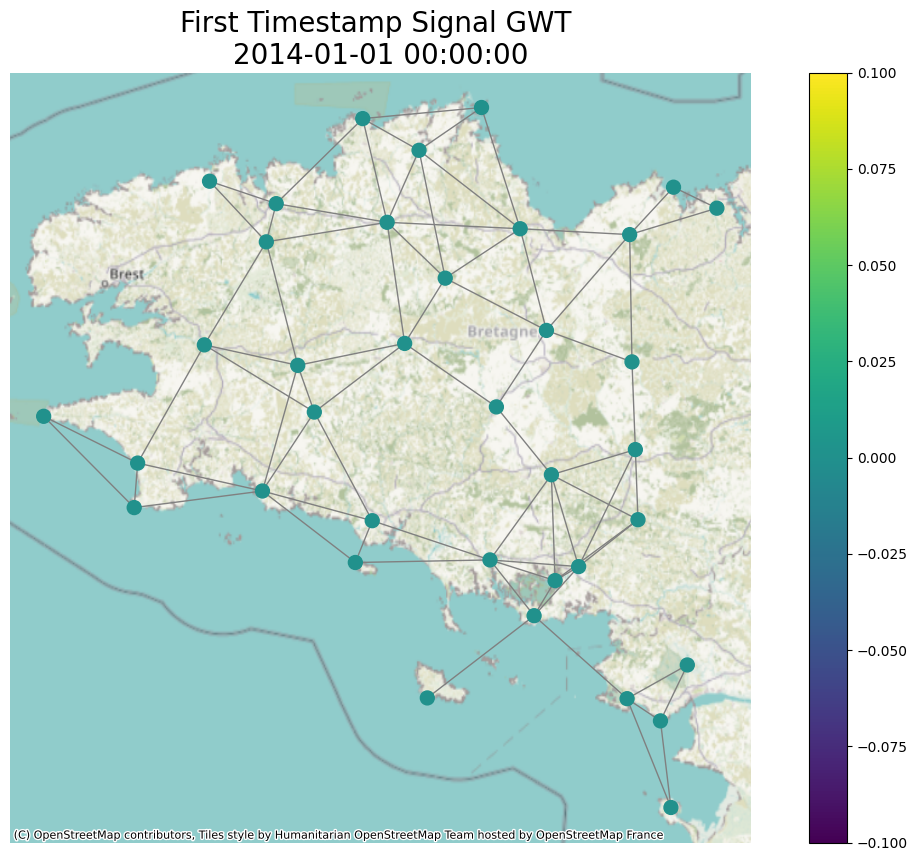

In [3]:
def g_hat(x, a, R):
    if np.abs(x) <= a * R:
        return np.cos((np.pi / 2) * x / (a * R)) ** 2
    return 0


def GWT(f, m, v, eigenvalues, eigenvectors, R, M):
    a = eigenvalues[-1] / (M + 1 - R)
    g_m = np.array([g_hat(lam_i - a * m, a, R) for lam_i in eigenvalues])
    f_hat = eigenvectors.T.dot(f)
    return np.sum(g_m * f_hat * eigenvectors[v, :])


def energy_class(f, eigenvalues, eigenvectors, R, M):
    V = len(f)
    energy = np.empty(V)
    
    for v in range(V):
        low, med, high = 0, 0, 0
        for m in range(M):
            coeff = GWT(f, m, v, eigenvalues, eigenvectors, R, M) ** 2
            if m < 3:
                low += coeff
            elif m < 6:
                med += coeff
            else:
                high += coeff
        energy[v] = np.argmax([low, med, high])
    return energy


least_smooth_signal = temperature_df.iloc[np.argmax(smoothness)].values
smoothest_signal = temperature_df.iloc[np.argmin(smoothness)].values
first_signal = temperature_df.iloc[0].values

L_np = G.L.toarray()
eigenvalues, eigenvectors = np.linalg.eigh(L_np)

least_smooth_classes = energy_class(least_smooth_signal, eigenvalues, eigenvectors, R=3, M=9)
smoothest_classes = energy_class(smoothest_signal, eigenvalues, eigenvectors, R=3, M=9)
first_classes = energy_class(first_signal, eigenvalues, eigenvectors, R=3, M=9)

ax = stations_gdf.geometry.plot(figsize=(15, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(stations_np)
G.plot_signal(least_smooth_classes, ax=ax)
plt.title(f"Least Smooth Signal GWT \n{temperature_df.index[np.argmax(smoothness)]}", fontsize=20)
plt.show()

ax = stations_gdf.geometry.plot(figsize=(15, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(stations_np)
G.plot_signal(smoothest_classes, ax=ax)
plt.title(f"Smoothest Signal GWT \n{temperature_df.index[np.argmin(smoothness)]}", fontsize=20)
plt.show()

ax = stations_gdf.geometry.plot(figsize=(15, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(stations_np)
G.plot_signal(first_classes, ax=ax)
plt.title(f"First Timestamp Signal GWT \n{temperature_df.index[0]}", fontsize=20)
plt.show()

# Question 6

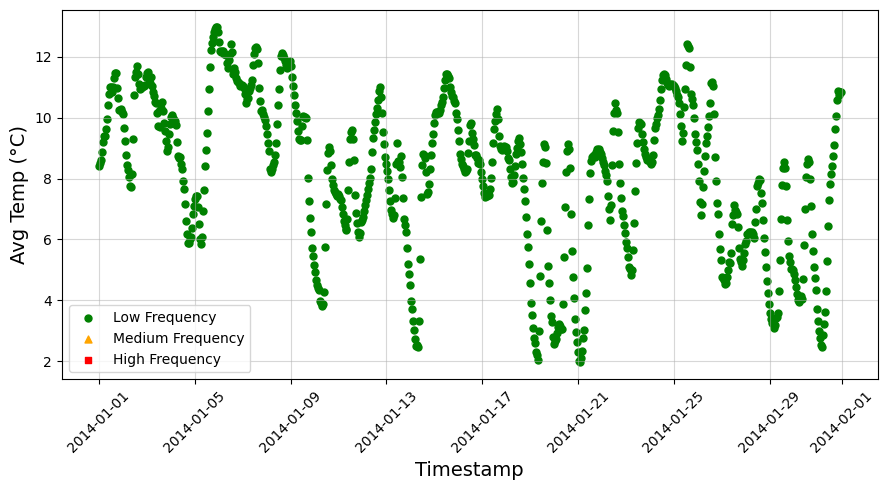

In [4]:
def majority_class(signal, eigenvalues, eigenvectors, R, M):
    node_classes = energy_class(signal, eigenvalues, eigenvectors, R, M)
    counts = np.bincount(node_classes.astype(int))
    return np.argmax(counts)


average_temperatures = []
majority_classes = []

for i in range(len(temperature_df)):
    signal = temperature_df.iloc[i].values
    avg_temp = np.mean(signal)
    avg_class = majority_class(signal, eigenvalues, eigenvectors, R=3, M=9)
    
    average_temperatures.append(avg_temp)
    majority_classes.append(avg_class)

class_colors = {0: 'green', 1: 'orange', 2: 'red'}
class_shapes = {0: 'o', 1: '^', 2: 's'}
class_labels = {0: 'Low Frequency', 1: 'Medium Frequency', 2: 'High Frequency'}

plt.figure(figsize=(9, 5))

for cls in class_colors.keys():
    indices = [i for i, c in enumerate(majority_classes) if c == cls]
    plt.scatter(
        temperature_df.index[indices],
        [average_temperatures[i] for i in indices],
        c=class_colors[cls],
        label=class_labels[cls],
        marker=class_shapes[cls],
        s=25
    )

plt.legend()
plt.xticks(rotation=45)
plt.xlabel("Timestamp", fontsize=14)
plt.ylabel("Avg Temp (°C)", fontsize=14)
plt.grid(True, alpha = 0.5)
plt.tight_layout()
plt.show()

# Question 7

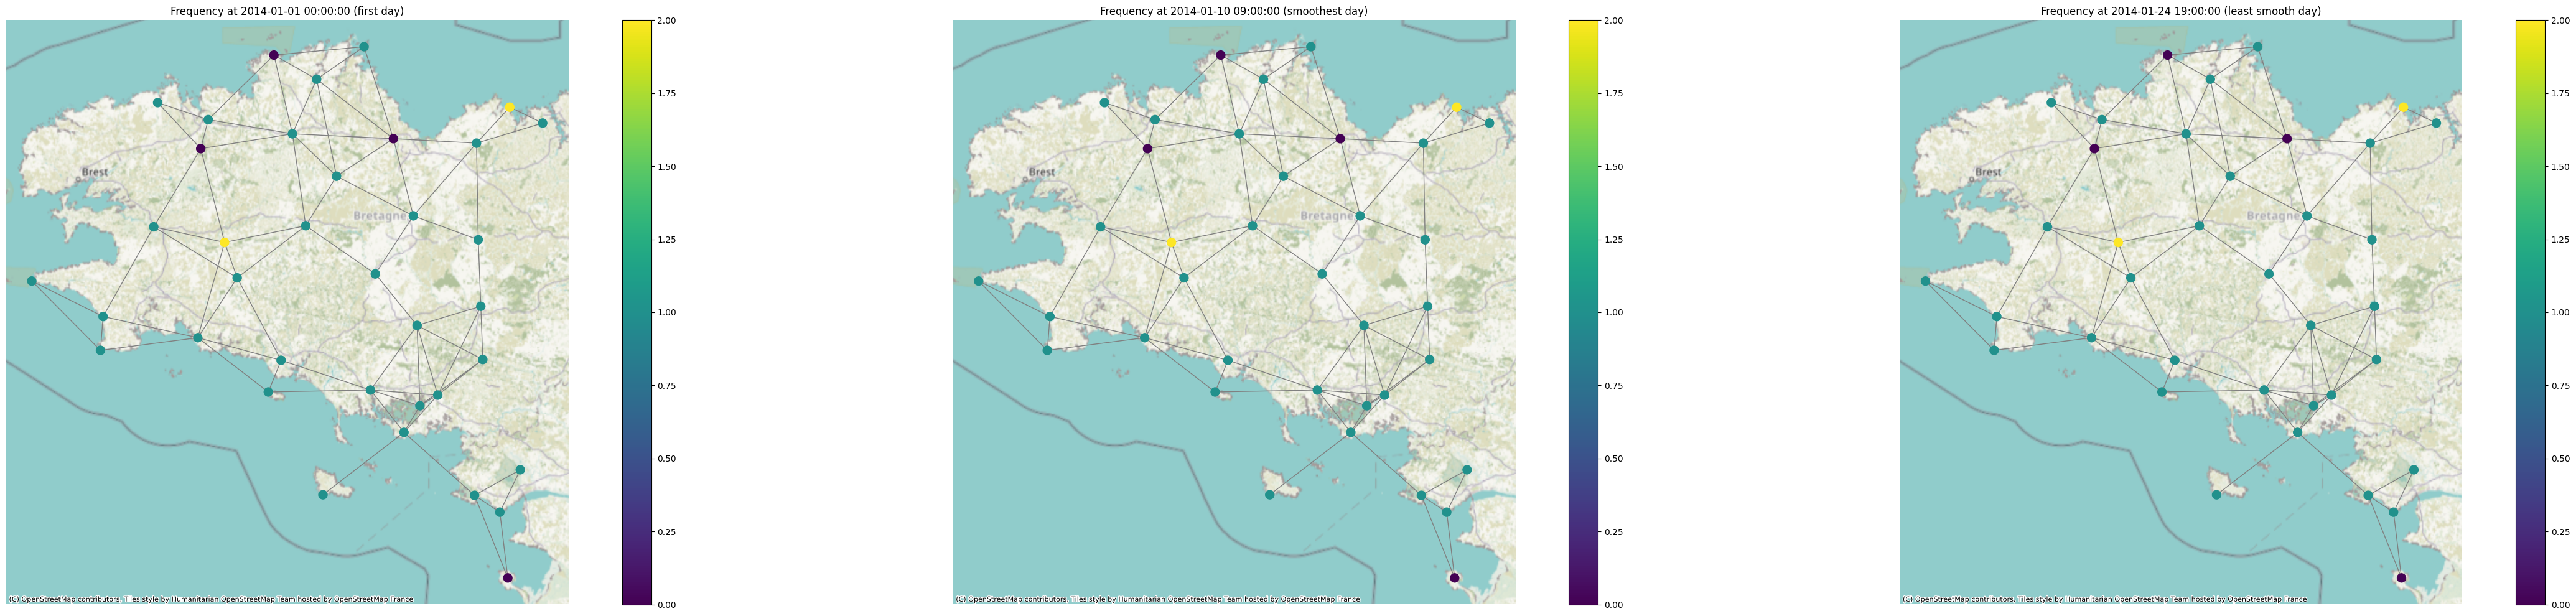

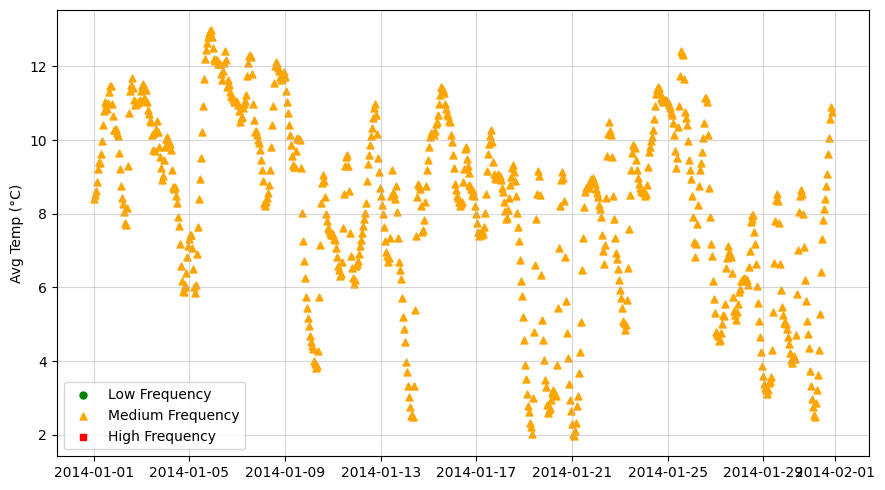

In [5]:
adjacency_line = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
line_graph = graphs.Graph(adjacency_line)


def gu(lambd, a, R):
    characteristic = np.logical_and(-R * a <= lambd, lambd <= 0).astype(float)
    cos = np.cos(2 * np.pi * (lambd / (a * R) + 0.5))
    return 0.5 * (1 + cos) * characteristic

def g_hat(lambd, m, R, M=9):
    a = 12 / (M + 1 - R)
    return gu(lambd - a * m, a, R)


def compute_graph_eigens(graph_a, graph_b):
    eigenvals_a, eigenvects_a = eigh(graph_a.L.todense())
    eigenvals_b, eigenvects_b = eigh(graph_b.L.todense())

    eigenvals, eigenvects = [], []
    for eigenval_a, eigenvect_a in zip(eigenvals_a, eigenvects_a):
        for eigenval_b, eigenvect_b in zip(eigenvals_b, eigenvects_b):
            eigenvals.append(eigenval_a + eigenval_b)
            eigenvects.append(np.kron(eigenvect_a, eigenvect_b))

    idx = np.argsort(eigenvals)
    eigenvals = np.array(eigenvals)[idx]
    eigenvects = np.array(eigenvects)[idx]
    return eigenvals, eigenvects.T

def calculate_wavelet_matrix(signal, graph_a, graph_b, M=9):
    eigenvals, eigenvects = compute_graph_eigens(graph_a, graph_b)

    W_matrix = np.zeros((M, len(eigenvects)))
    g = np.stack([g_hat(eigenvals, i, R=3, M=9) for i in range(1, M+1)])
    f_hat = signal.T @ eigenvects

    for idx, v in enumerate(eigenvects):
        ul_v = eigenvects[idx, :]
        w = g * f_hat[None, :] * ul_v[None, :]
        W_matrix[:, idx] = np.sum(w, axis=1)

    return W_matrix

def classify_wavelet_coefficients(W_matrix):
    classified = np.zeros(W_matrix.shape[1], dtype=int)
    for idx in range(W_matrix.shape[1]):
        low, medium, high = 0, 0, 0
        for m in range(W_matrix.shape[0]):
            coeff = W_matrix[m, idx] ** 2
            if m < 3:
                low += coeff
            elif m < 6:
                medium += coeff
            else:
                high += coeff
        classified[idx] = np.argmax([low, medium, high])
    return classified

dynamic_signal = np.array(temperature_df.iloc[1:4].T).flatten()
W_dynamic = calculate_wavelet_matrix(dynamic_signal, G, line_graph, M=9)

W_dynamic_reshaped = W_dynamic.reshape((9, len(STATION_LIST), -1))
W_dynamic_classified = classify_wavelet_coefficients(W_dynamic_reshaped.sum(axis=2))

fig, axs = plt.subplots(1, 3, figsize=(48, 10))
for idx, (day, W_classified) in enumerate(
    {
        f"{temperature_df.index[0]} (first day)": W_dynamic_classified,
        f"{temperature_df.index[np.argmax(smoothness)]} (smoothest day)": W_dynamic_classified,
        f"{temperature_df.index[np.argmin(smoothness)]} (least smooth day)": W_dynamic_classified,
    }.items()
):
    ax = axs[idx]
    ax = stations_gdf.geometry.plot(figsize=(10, 5), ax=ax)
    cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
    ax.set_axis_off()

    G.set_coordinates(stations_np)
    G.plot_signal(W_classified, ax=ax, limits=[0, 2])
    ax.set_title(f"Frequency at {day}")
plt.tight_layout()

major_class = []
for idx in range(1, len(temperature_df) - 1):
    W = calculate_wavelet_matrix(temperature_df.iloc[idx - 1 : idx + 2].to_numpy().flatten(), G, line_graph)

    W_reshaped = W.reshape((9, len(STATION_LIST), -1))
    W_classified = classify_wavelet_coefficients(W_reshaped.sum(axis=2))
    values, counts = np.unique(W_classified, return_counts=True)
    major_value = values[np.argmax(counts)]
    major_class.append(major_value)
major_class = np.array(major_class)

fig, ax = plt.subplots(1, 1, figsize=(9, 5))


for cls in class_colors.keys():
    indices = [i for i, c in enumerate(major_class) if c == cls]
    plt.scatter(
        temperature_df.index[indices],
        [average_temperatures[i] for i in indices],
        c=class_colors[cls],
        label=class_labels[cls],
        marker=class_shapes[cls],
        s=25
    )
ax.set_ylabel("Avg Temp (°C)")
ax.legend()
plt.tight_layout()
plt.grid(True, alpha = 0.5)
plt.show()